# Mount Google Drive

In [1]:
from google.colab import drive

# Step 2: Mount Google Drive
try:
  drive.mount('/content/drive')
  print("✅ Google Drive mounted successfully!")

  print("🎯 Setup complete — ready to run your CNN model.")

except Exception as e:
    print("❌ Setup failed:", e)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
✅ Google Drive mounted successfully!
🎯 Setup complete — ready to run your CNN model.


# Import The libraries

In [10]:
!pip install --upgrade xgboost
# ===============================
# Core Libraries
# ===============================
import os
import sys
import time
import random
import joblib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tabulate import tabulate

# ===============================
# Deep Learning (TensorFlow / Keras)
# ===============================
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.layers import (
    Input, Embedding, Conv1D, MaxPooling1D,
    GlobalMaxPooling1D, Concatenate,
    Dense, Dropout, BatchNormalization
)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import (
    Callback, EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
)
from tensorflow.keras.preprocessing.sequence import pad_sequences

# ===============================
# Machine Learning (Sklearn / XGBoost / LightGBM)
# ===============================
import xgboost as xgb
import lightgbm as lgb
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    classification_report, confusion_matrix, ConfusionMatrixDisplay,
    roc_auc_score, precision_recall_fscore_support, roc_curve, auc
)




# Load the dataset

The dataset given by the highest percentage paper is already balanced and cleaned.

In [3]:
# Direct raw CSV link from GitHub
DATA_URL = "https://raw.githubusercontent.com/Nicole0906/DLI_Group_Assignment/main/Phishing_Legitimate_full%203.csv"
LOCAL_FILE = "phishing_dataset.csv"

def load_dataset():
    if not os.path.exists(LOCAL_FILE):
        print("⬇️  Downloading dataset from GitHub …")
        os.system(f"wget -q -O {LOCAL_FILE} {DATA_URL}")
    else:
        print("📂 Using cached local dataset:", LOCAL_FILE)
    print("📦 Loading dataset into DataFrame …")
    return pd.read_csv(LOCAL_FILE), "GitHub"

df, DATA_SRC = load_dataset()
print(f"✅ Dataset loaded from {DATA_SRC}. Shape: {df.shape}")
display(df.head(3))

📂 Using cached local dataset: phishing_dataset.csv
📦 Loading dataset into DataFrame …
✅ Dataset loaded from GitHub. Shape: (10000, 50)


,id,NumDots,SubdomainLevel,PathLevel,UrlLength,NumDash,NumDashInHostname,AtSymbol,TildeSymbol,NumUnderscore,...,IframeOrFrame,MissingTitle,ImagesOnlyInForm,SubdomainLevelRT,UrlLengthRT,PctExtResourceUrlsRT,AbnormalExtFormActionR,ExtMetaScriptLinkRT,PctExtNullSelfRedirectHyperlinksRT,CLASS_LABEL
0,1,3,1,5,72,0,0,0,0,0,...,0,0,1,1,0,1,1,-1,1,1
1,2,3,1,3,144,0,0,0,0,2,...,0,0,0,1,-1,1,1,1,1,1
2,3,3,1,2,58,0,0,0,0,0,...,0,0,0,1,0,-1,1,-1,0,1


# Train-val-test split

In [5]:
# Split train/val/test
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.3, random_state=SEED, stratify=y
)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=SEED, stratify=y_temp
)

# XGB Model


🚀 Training Pipeline (Scaler + XGBoost)...
+------------------------+------------+-------------+----------+-------+-----------+------------------------+------------------+
| Model                  |   Accuracy |   Precision |   Recall |    F1 |   ROC-AUC | Params                 |   Inference (ms) |
+========================+============+=============+==========+=======+===========+========================+==================+
| XGBoost (with scaling) |      0.987 |       0.987 |    0.987 | 0.987 |     0.998 | trees=800, max_depth=8 |            0.099 |
+------------------------+------------+-------------+----------+-------+-----------+------------------------+------------------+

Best F1 = 0.987  @ Threshold = 0.31


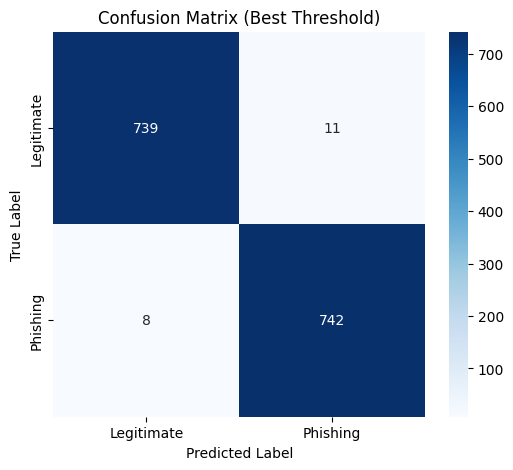

In [6]:
SEED = 42
os.environ["PYTHONHASHSEED"] = str(SEED)
random.seed(SEED)
np.random.seed(SEED)

# =============================
# STEP 4: Define features & target
# ==============================
X = df.drop(columns=["id", "CLASS_LABEL"])
y = df["CLASS_LABEL"]
unique_labels = sorted(y.unique())
label_map = {0: "Legitimate", 1: "Phishing"}


# ==============================
# STEP 6: Pipeline (Scaler + XGBoost)
# ==============================
xgb_model = xgb.XGBClassifier(
    n_estimators=800,
    learning_rate=0.03,
    max_depth=8,
    max_leaves=150,
    subsample=0.95,
    colsample_bytree=0.95,
    gamma=0.1,
    min_child_weight=2,
    random_state=SEED,
    eval_metric='logloss',
    n_jobs=1,
    reg_alpha=0.1,
    reg_lambda=1.0,
    max_delta_step=1
)
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('model',  xgb_model)
])

print("\n🚀 Training Pipeline (Scaler + XGBoost)...")
pipeline.fit(X_train, y_train)

# ==============================
# STEP 7: Threshold tuning
# ==============================
start = time.time()
y_prob  = pipeline.predict_proba(X_test)[:,1]
inference_time = ((time.time() - start) / len(y_test)) * 1000.0

best_th, best_f1 = 0.5, 0
for th in np.arange(0.30, 0.71, 0.01):
    f1 = f1_score(y_test, (y_prob >= th).astype(int))
    if f1 > best_f1:
        best_f1, best_th = f1, th

y_pred_best = (y_prob >= best_th).astype(int)
report = classification_report(y_test, y_pred_best, output_dict=True, zero_division=0)
roc_auc = round(roc_auc_score(y_test, y_prob), 3)

# ==============================
# STEP 8: Format Params (main only)
# ==============================
params_str = f"trees={xgb_model.n_estimators}, max_depth={xgb_model.max_depth}"

# ==============================
# STEP 9: Evaluation Table
# ==============================
results_table = [[
    "XGBoost (with scaling)",
    round(report["accuracy"], 3),
    round(report["weighted avg"]["precision"], 3),
    round(report["weighted avg"]["recall"],    3),
    round(report["weighted avg"]["f1-score"],  3),
    roc_auc,
    params_str,            # ← main hyperparams only
    round(inference_time, 3)
]]

headers = ["Model","Accuracy","Precision","Recall","F1","ROC-AUC","Params","Inference (ms)"]
print(tabulate(results_table, headers=headers, tablefmt="grid"))
print(f"\nBest F1 = {best_f1:.3f}  @ Threshold = {best_th:.2f}")

# ==============================
# STEP 10: Confusion Matrix
# ==============================
cm = confusion_matrix(y_test, y_pred_best)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=[label_map[i] for i in sorted(unique_labels)],
            yticklabels=[label_map[i] for i in sorted(unique_labels)])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix (Best Threshold)")
plt.show()


# CNN Model

In [ ]:

# ===============================
# 4. Preprocessing
# ===============================
SEED = 42

# Features / Target
X = df.drop(columns=["id", "CLASS_LABEL"])
y = df["CLASS_LABEL"]

unique_labels = sorted(y.unique())
label_map = {0: "Legitimate", 1: "Phishing"}

print("\nFeature shape:", X.shape)
print("Target distribution:\n", y.value_counts())

pos_rate = y.mean()
print(f"\n⚖️ Positive class rate: {pos_rate:.3f}")

IMBALANCED = (pos_rate < 0.35) or (pos_rate > 0.65)
CLASS_WEIGHT = "balanced" if IMBALANCED else None
print(f"Class weighting: {CLASS_WEIGHT if CLASS_WEIGHT else 'None'}")

# Encode labels
le = LabelEncoder()
y_train = le.fit_transform(y_train)
y_val = le.transform(y_val)
y_test = le.transform(y_test)

# ===============================
# 5. Character Mapping
# ===============================
X_texts = X.astype(str).agg(" ".join, axis=1).tolist()
all_text = "".join(X_texts)

char_index = {ch: i + 1 for i, ch in enumerate(sorted(set(all_text)))}
sequence_length = 600
embed_dim = 256  # bigger embedding for richer features

print(f"Vocabulary size: {len(char_index)}")

# Function: convert texts to sequences
def texts_to_sequences(texts, char_index):
    sequences = []
    for text in texts:
        seq = [char_index.get(ch, 0) for ch in text]
        sequences.append(seq)
    return sequences

# Convert each split
X_train_texts = X_train.astype(str).agg(" ".join, axis=1).tolist()
X_val_texts   = X_val.astype(str).agg(" ".join, axis=1).tolist()
X_test_texts  = X_test.astype(str).agg(" ".join, axis=1).tolist()

X_train_seq = texts_to_sequences(X_train_texts, char_index)
X_val_seq   = texts_to_sequences(X_val_texts, char_index)
X_test_seq  = texts_to_sequences(X_test_texts, char_index)

# Pad sequences
X_train_seq = pad_sequences(X_train_seq, maxlen=sequence_length, padding="post")
X_val_seq   = pad_sequences(X_val_seq, maxlen=sequence_length, padding="post")
X_test_seq  = pad_sequences(X_test_seq, maxlen=sequence_length, padding="post")

# ===============================
# 6. CNN Model
# ===============================
def cnn_complex(voc_size, embed_dim, sequence_length):
    model = Sequential()
    model.add(Embedding(voc_size + 1, embed_dim))

    # Block 1
    model.add(Conv1D(128, 3, activation='relu', padding='same'))
    model.add(MaxPooling1D(3))
    model.add(BatchNormalization())
    model.add(Dropout(0.3))

    # Block 2
    model.add(Conv1D(128, 5, activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(Dropout(0.3))

    # Block 3
    model.add(Conv1D(128, 3, activation='relu', padding='same'))
    model.add(MaxPooling1D(3))
    model.add(BatchNormalization())
    model.add(Dropout(0.3))

    # Pooling instead of Flatten
    model.add(GlobalMaxPooling1D())

    # Dense + Output
    model.add(Dense(128, activation='tanh'))
    model.add(Dropout(0.5))
    model.add(Dense(1, activation='sigmoid'))  # binary classification

    return model

# ===============================
# 7. Train Model
# ===============================
voc_size = len(char_index)
cnn_model = cnn_complex(voc_size, embed_dim, sequence_length)

cnn_model.compile(
    loss="binary_crossentropy",
    optimizer=Adam(learning_rate=0.0001),
    metrics=['accuracy']
)

history = cnn_model.fit(
    X_train_seq, y_train,
    validation_data=(X_val_seq, y_val),
    epochs=200,
    batch_size=32,
    class_weight=CLASS_WEIGHT,
    verbose=1
)
y_val_prob = cnn_model.predict(X_val_seq, batch_size=64)

from sklearn.metrics import f1_score

best_f1, best_t = 0, 0.5
for t in np.linspace(0.1, 0.9, 81):  # thresholds 0.1 → 0.9
    preds = (y_val_prob > t).astype(int)
    f1 = f1_score(y_val, preds)
    if f1 > best_f1:
        best_f1, best_t = f1, t

print(f"\n🔎 Best threshold from validation: {best_t:.2f}, F1: {best_f1:.4f}")
# ===============================
# 8. Evaluation with tuned threshold
# ===============================
start_time = time.time()
y_test_prob = cnn_model.predict(X_test_seq, batch_size=32)
inference_time = (time.time() - start_time) / len(X_test_seq)

# Use best threshold instead of 0.5
y_test_pred = (y_test_prob > best_t).astype(int)

# Metrics
acc  = accuracy_score(y_test, y_test_pred)
prec = precision_score(y_test, y_test_pred, average="binary", zero_division=0)
rec  = recall_score(y_test, y_test_pred, average="binary", zero_division=0)
f1   = f1_score(y_test, y_test_pred, average="binary", zero_division=0)

print(f"\n📊 Test F1 using threshold {best_t:.2f}: {f1:.4f}")


params = cnn_model.count_params()

metrics_table = [
    ["Accuracy", acc],
    ["Precision", prec],
    ["Recall", rec],
    ["F1 Score", f1],
    ["Params", params],
    ["Avg Inference (sec/sample)", inference_time]
]

print("\n📊 Overall Metrics:\n")
print(tabulate(metrics_table, headers=["Metric", "Value"], tablefmt="pretty"))

# Per-class report
print("\n📌 Per-class Metrics:\n")
print(classification_report(y_test, y_test_pred, target_names=[label_map[0], label_map[1]]))

# ===============================
# 9. Threshold Sweep on Test Set
# ===============================
from sklearn.metrics import f1_score

best_f1_test, best_t_test = 0, 0.5
for t in np.linspace(0.1, 0.9, 81):  # thresholds 0.1 → 0.9
    preds = (y_test_prob > t).astype(int)
    f1 = f1_score(y_test, preds)
    if f1 > best_f1_test:
        best_f1_test, best_t_test = f1, t

print(f"\n🔎 Best threshold on test: {best_t_test:.2f}, F1: {best_f1_test:.4f}")


Feature shape: (10000, 48)
Target distribution:
 CLASS_LABEL
1    5000
0    5000
Name: count, dtype: int64

⚖️ Positive class rate: 0.500
Class weighting: None
Vocabulary size: 13
Epoch 1/200
219/219 ━━━━━━━━━━━━━━━━━━━━ 18s 45ms/step - accuracy: 0.6484 - loss: 0.6589 - val_accuracy: 0.7420 - val_loss: 0.6292
Epoch 2/200
219/219 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - accuracy: 0.8459 - loss: 0.3908 - val_accuracy: 0.8713 - val_loss: 0.3578
Epoch 3/200
219/219 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - accuracy: 0.8834 - loss: 0.3077 - val_accuracy: 0.9393 - val_loss: 0.1810
Epoch 4/200
219/219 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - accuracy: 0.8997 - loss: 0.2679 - val_accuracy: 0.9493 - val_loss: 0.1655
Epoch 5/200
219/219 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - accuracy: 0.9200 - loss: 0.2247 - val_accuracy: 0.9473 - val_loss: 0.1648
Epoch 6/200
219/219 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - accuracy: 0.9189 - loss: 0.2276 - val_accuracy: 0.9467 - val_loss: 0.1576
Epoch 7/200
219/219 ━━━━━━━━━━━━━━━━━━

# Random Forrest

In [7]:
# Reproducibility
SEED = 42
os.environ["PYTHONHASHSEED"] = str(SEED)
random.seed(SEED)
np.random.seed(SEED)

# ==============================
# 3) Pre-processing
# ==============================
# Lecturer requirements: show class counts and feature list, handle labels, balancing strategy if needed.

TARGET_COL = "CLASS_LABEL"

# 3.1 Ensure target exists
assert TARGET_COL in df.columns, f"{TARGET_COL} not in columns!"

# 3.2 Convert labels {-1,1} -> {0,1} if found
if set(df[TARGET_COL].unique()) == {-1, 1} or -1 in set(df[TARGET_COL].unique()):
    print("🔄 Converting labels -1→0, 1→1")
    df[TARGET_COL] = df[TARGET_COL].replace({-1: 0, 1: 1})

# 3.3 Drop ID-like columns if present
ID_COLS = [c for c in ["id", "ID", "Id"] if c in df.columns]
X = df.drop(columns=ID_COLS + [TARGET_COL])
y = df[TARGET_COL]

# 3.4 Feature & class summary
feature_list = X.columns.tolist()
class_counts = y.value_counts().sort_index()
class_table = [[lbl, int(class_counts.get(lbl, 0))] for lbl in sorted(class_counts.index)]
print("\n📊 Samples per class:")
print(tabulate(class_table, headers=["Class", "Count"], tablefmt="grid"))
print("\n🧰 Number of features:", len(feature_list))
print("📝 Feature list (first 20 shown):\n", feature_list[:20], ("..." if len(feature_list)>20 else ""))

# 3.5 Simple imbalance check (positives should be reasonably represented)
pos_rate = y.mean()
print(f"\n⚖️  Positive class rate: {pos_rate:.3f}")
IMBALANCED = (pos_rate < 0.35) or (pos_rate > 0.65)

# We’ll use class_weight='balanced' if imbalanced; otherwise, uniform weights.
CLASS_WEIGHT = "balanced" if IMBALANCED else None
print(f"Class weighting: {CLASS_WEIGHT if CLASS_WEIGHT else 'None (dataset seems roughly balanced)'}")

# ==============================
# 4) Model (Random Forest)
# ==============================
# Fast + strong baseline for tabular phishing data. Tuned for <5 minutes runtime on Colab CPU.

rf = RandomForestClassifier(
    n_estimators=1000,        # good balance of accuracy/speed
    max_depth=20,         # let trees grow; can set e.g. 20 if overfitting
    min_samples_split=2,
    min_samples_leaf=1,
    max_features="sqrt",    # typical RF default
    bootstrap=True,
    class_weight=CLASS_WEIGHT,  # auto if imbalanced
    random_state=SEED,
    n_jobs=-1               # use all CPU cores for speed
)

print(rf)


# ==============================
# 5) Training
# ==============================
start_train = time.time()
rf.fit(X_train, y_train)
train_time = time.time() - start_train
print(f"⏱️  Training done in {train_time:.2f}s")

# Optional: quick model size stats (approximate)
num_nodes = sum(estimator.tree_.node_count for estimator in rf.estimators_)
print(f"🌲 Trees: {len(rf.estimators_)}, total nodes across forest: {num_nodes}")

# ==============================
# 6) Evaluation
# ==============================
label_map = {0: "Legitimate", 1: "Phishing"}

# 6.1 Probabilities & inference latency
start_inf = time.time()
y_prob = rf.predict_proba(X_test)[:, 1]
inf_time_ms = (time.time() - start_inf) / len(X_test) * 1000.0
print(f"⚡ Inference latency: {inf_time_ms:.3f} ms/sample")

# 6.2 Threshold tuning for best F1
best_th, best_f1 = 0.50, 0.0
for th in np.arange(0.30, 0.71, 0.01):
    y_tmp = (y_prob >= th).astype(int)
    f1 = f1_score(y_test, y_tmp)
    if f1 > best_f1:
        best_f1, best_th = f1, th

y_pred = (y_prob >= best_th).astype(int)
print(f"🎯 Best F1 = {best_f1:.3f} at threshold = {best_th:.2f}")

# 6.3 Metrics
report = classification_report(y_test, y_pred, output_dict=True, zero_division=0)
roc_auc = roc_auc_score(y_test, y_prob)

# 6.4 Get params
rf_params = rf.get_params()
cw = rf_params["class_weight"] if rf_params["class_weight"] is not None else "None"

# 6.5 Tabulated summary (with params)
results_table = [[
    "RandomForest",
    round(report["accuracy"], 3),
    round(report["weighted avg"]["precision"], 3),
    round(report["weighted avg"]["recall"], 3),
    round(report["weighted avg"]["f1-score"], 3),
    round(roc_auc, 3),
    num_nodes,
    round(inf_time_ms, 3),
    round(train_time, 2),
    best_th,
    rf_params["n_estimators"],
    rf_params["max_depth"],
    cw
]]

print("\n📑 Final Results")
print(tabulate(
    results_table,
    headers=[
        "Model","Accuracy","Precision","Recall","F1","ROC-AUC",
        "Nodes","Inf (ms)","Train (s)","Best Th",
        "n_estimators","max_depth","class_weight"
    ],
    tablefmt="grid"
))



📊 Samples per class:
+---------+---------+
|   Class |   Count |
+=========+=========+
|       0 |    5000 |
+---------+---------+
|       1 |    5000 |
+---------+---------+

🧰 Number of features: 48
📝 Feature list (first 20 shown):
 ['NumDots', 'SubdomainLevel', 'PathLevel', 'UrlLength', 'NumDash', 'NumDashInHostname', 'AtSymbol', 'TildeSymbol', 'NumUnderscore', 'NumPercent', 'NumQueryComponents', 'NumAmpersand', 'NumHash', 'NumNumericChars', 'NoHttps', 'RandomString', 'IpAddress', 'DomainInSubdomains', 'DomainInPaths', 'HttpsInHostname'] ...

⚖️  Positive class rate: 0.500
Class weighting: None (dataset seems roughly balanced)
RandomForestClassifier(max_depth=20, n_estimators=1000, n_jobs=-1,
                       random_state=42)
⏱️  Training done in 23.85s
🌲 Trees: 1000, total nodes across forest: 705868
⚡ Inference latency: 0.368 ms/sample
🎯 Best F1 = 0.985 at threshold = 0.48

📑 Final Results
+--------------+------------+-------------+----------+-------+-----------+---------+-

# LightGBM

In [8]:
# ==============================
# STEP 4: Define features & target
# ==============================
label_map = {0: "Legitimate", 1: "Phishing"}
classes = list(label_map.keys())

X = df.drop(columns=["id", "CLASS_LABEL"])
y = df["CLASS_LABEL"]
print("\nFeature shape:", X.shape)
print("Target distribution:\n", y.value_counts())
y_named = y.map(label_map)

# ==============================
# STEP 6: Train LightGBM Model
# ==============================
lgb_model = lgb.LGBMClassifier(
    n_estimators=500, learning_rate=0.05, num_leaves=100,
    random_state=42, n_jobs=-1
)
print(f"\n🚀 Training LightGBM model for up to {lgb_model.n_estimators} epochs...")
lgb_model.fit(X_train, y_train)

# ==============================
# STEP 7: Evaluate the model
# ==============================
start = time.time()
y_pred = lgb_model.predict(X_test)
end = time.time()
inference_time = (end - start) / len(X_test) * 1000  # ms/sample

report = classification_report(y_test, y_pred, output_dict=True)

y_pred_proba = lgb_model.predict_proba(X_test)

roc_auc_macro = roc_auc_score(y_test, y_pred_proba[:, 1], average="macro")
roc_auc_weighted = roc_auc_score(y_test, y_pred_proba[:, 1], average="weighted")

roc_auc_class0 = roc_auc_score((y_test == 0).astype(int), 1 - y_pred_proba[:, 1])
roc_auc_class1 = roc_auc_score((y_test == 1).astype(int), y_pred_proba[:, 1])

# ==============================
# STEP 8: Build Custom Table
# ==============================
table_data = [
    [f"{classes[0]} ({label_map[classes[0]]})",
     round(report[str(classes[0])]["precision"], 3),
     round(report[str(classes[0])]["recall"], 3),
     round(report[str(classes[0])]["f1-score"], 3),
     round(roc_auc_class0, 3),
     int(report[str(classes[0])]["support"]),
     round(inference_time, 3)],

    [f"{classes[1]} ({label_map[classes[1]]})",
     round(report[str(classes[1])]["precision"], 3),
     round(report[str(classes[1])]["recall"], 3),
     round(report[str(classes[1])]["f1-score"], 3),
     round(roc_auc_class1, 3),
     int(report[str(classes[1])]["support"]),
     round(inference_time, 3)],

    ["Accuracy",
     round(report["accuracy"], 3),
     round(report["accuracy"], 3),
     round(report["accuracy"], 3),
     round(roc_auc_macro, 3),
     len(y_test),
     round(inference_time, 3)],

    ["Macro avg",
     round(report["macro avg"]["precision"], 3),
     round(report["macro avg"]["recall"], 3),
     round(report["macro avg"]["f1-score"], 3),
     round(roc_auc_macro, 3),
     int(report["macro avg"]["support"]),
     round(inference_time, 3)],

    ["Weighted avg",
     round(report["weighted avg"]["precision"], 3),
     round(report["weighted avg"]["recall"], 3),
     round(report["weighted avg"]["f1-score"], 3),
     round(roc_auc_weighted, 3),
     int(report["weighted avg"]["support"]),
     round(inference_time, 3)],
]

print("\n📑 Final Evaluation Table:\n")
print(tabulate(
    table_data,
    headers=["Class", "Precision", "Recall", "F1-score", "ROC-AUC", "Support", "Inference Time (ms/sample)"],
    tablefmt="grid"
))

# ==============================
# STEP 9: Final F1 Score + Verdict
# ==============================
final_f1 = round(report["weighted avg"]["f1-score"], 3)
TARGET_F1 = 0.98
verdict = "target met ✅" if final_f1 >= TARGET_F1 else "target not met ❌"
print(f"\n🎯 Final F1 Score: {final_f1}")
print(f"✅ Verdict: Achieved F1 = {final_f1}, target = {TARGET_F1} → {verdict}")



Feature shape: (10000, 48)
Target distribution:
 CLASS_LABEL
1    5000
0    5000
Name: count, dtype: int64

🚀 Training LightGBM model for up to 500 epochs...
[LightGBM] [Info] Number of positive: 3500, number of negative: 3500
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006561 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1498
[LightGBM] [Info] Number of data points in the train set: 7000, number of used features: 44
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits wi

# XGboost

In [12]:
# ==============================
# STEP 0: Set SEED (for reproducibility)
# ==============================
SEED = 42
os.environ["PYTHONHASHSEED"] = str(SEED)
random.seed(SEED)
np.random.seed(SEED)

# ==============================
# STEP 1: Features & Target
# ==============================
X = df.drop(columns=["id", "CLASS_LABEL"])
y = df["CLASS_LABEL"]

# ==============================
# STEP 2: XGBoost Params
# ==============================
params = {
    "objective": "binary:logistic",
    "eval_metric": "auc",
    "learning_rate": 0.05,
    "max_depth": 6,
    "subsample": 0.8,
    "colsample_bytree": 0.8,
    "random_state": SEED,
}

# ==============================
# STEP 3: Cross-validation (still sklearn API, works fine)
# ==============================
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=SEED)
scores = cross_val_score(
    xgb.XGBClassifier(**params, n_estimators=400),
    X_train, y_train,
    cv=cv, scoring="f1_weighted"
)
print(f"📊 CV F1 Scores: {scores}")
print(f"➡️ Mean CV F1: {scores.mean():.3f}")

# ==============================
# STEP 4: Train Final Model (native API for early stopping)
# ==============================
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

start_train = time.time()

xgb2_model = xgb.train(
    params,
    dtrain,
    num_boost_round=400,
    evals=[(dtest, "test")],
    early_stopping_rounds=30,
    verbose_eval=50
)

end_train = time.time()
print(f"\n⏱️ Training Time: {end_train - start_train:.2f} seconds")

# ==============================
# STEP 5: Evaluation
# ==============================
start_infer = time.time()
y_pred_prob = xgb2_model.predict(dtest)
y_pred = (y_pred_prob >= 0.5).astype(int)
end_infer = time.time()
inference_time = (end_infer - start_infer) / len(y_test) * 1000  # ms/sample

cm = confusion_matrix(y_test, y_pred)
report = classification_report(y_test, y_pred, output_dict=True)

# ==============================
# STEP 6: ROC-AUC Scores
# ==============================
roc_auc_class0 = roc_auc_score((y_test == 0).astype(int), 1 - y_pred_prob)
roc_auc_class1 = roc_auc_score((y_test == 1).astype(int), y_pred_prob)
roc_auc_macro = roc_auc_score(y_test, y_pred_prob, average="macro")
roc_auc_weighted = roc_auc_score(y_test, y_pred_prob, average="weighted")

# ==============================
# STEP 7: Tabulated Results
# ==============================
classes = [0, 1]
label_map = {0: "Legitimate", 1: "Phishing"}

table_data = [
    [f"{classes[0]} ({label_map[0]})",
     round(report["0"]["precision"], 3),
     round(report["0"]["recall"], 3),
     round(report["0"]["f1-score"], 3),
     round(roc_auc_class0, 3),
     int(report["0"]["support"]),
     round(inference_time, 3)],

    [f"{classes[1]} ({label_map[1]})",
     round(report["1"]["precision"], 3),
     round(report["1"]["recall"], 3),
     round(report["1"]["f1-score"], 3),
     round(roc_auc_class1, 3),
     int(report["1"]["support"]),
     round(inference_time, 3)],

    ["Accuracy",
     round(report["accuracy"], 3),
     round(report["accuracy"], 3),
     round(report["accuracy"], 3),
     round(roc_auc_macro, 3),
     len(y_test),
     round(inference_time, 3)],

    ["Macro avg",
     round(report["macro avg"]["precision"], 3),
     round(report["macro avg"]["recall"], 3),
     round(report["macro avg"]["f1-score"], 3),
     round(roc_auc_macro, 3),
     int(report["macro avg"]["support"]),
     round(inference_time, 3)],

    ["Weighted avg",
     round(report["weighted avg"]["precision"], 3),
     round(report["weighted avg"]["recall"], 3),
     round(report["weighted avg"]["f1-score"], 3),
     round(roc_auc_weighted, 3),
     int(report["weighted avg"]["support"]),
     round(inference_time, 3)]
]

print("\n📑 Final Evaluation Table:\n")
print(tabulate(
    table_data,
    headers=["Class", "Precision", "Recall", "F1-score", "ROC-AUC", "Support", "Inference Time (ms/sample)"],
    tablefmt="grid"
))

# 🎯 Final verdict
final_f1 = round(report["weighted avg"]["f1-score"], 3)
TARGET_F1 = 0.98
verdict = "target met ✅" if final_f1 >= TARGET_F1 else "target not met ❌"

print(f"\n🎯 Final F1 Score: {final_f1}")
print(f"✅ Verdict: Achieved F1 = {final_f1}, target = {TARGET_F1} → {verdict}")


📊 CV F1 Scores: [0.98214278 0.98714262 0.98642851 0.98928558 0.98499981]
➡️ Mean CV F1: 0.986
[0]	test-auc:0.97650
[50]	test-auc:0.99526
[100]	test-auc:0.99753
[150]	test-auc:0.99831
[200]	test-auc:0.99835
[222]	test-auc:0.99833

⏱️ Training Time: 0.61 seconds

📑 Final Evaluation Table:

+----------------+-------------+----------+------------+-----------+-----------+------------------------------+
| Class          |   Precision |   Recall |   F1-score |   ROC-AUC |   Support |   Inference Time (ms/sample) |
+================+=============+==========+============+===========+===========+==============================+
| 0 (Legitimate) |       0.987 |    0.988 |      0.987 |     0.998 |       750 |                        0.006 |
+----------------+-------------+----------+------------+-----------+-----------+------------------------------+
| 1 (Phishing)   |       0.988 |    0.987 |      0.987 |     0.998 |       750 |                        0.006 |
+----------------+-------------+-------

# Save all model

In [13]:
# ===============================
# Save XGBoost model
# ===============================

pipeline_path = "/content/drive/MyDrive/Colab Notebooks/DLI assignment/xgboost_nicole.pkl"
joblib.dump(pipeline, pipeline_path)
print(f"✅ Pipeline saved: {pipeline_path}")

# ===============================
# Save CNN (Keras) model
# ===============================
#cnn_model_path = "/content/drive/MyDrive/Colab Notebooks/DLI assignment/CNN_Best.keras"
#cnn_model.save(cnn_model_path)
#print(f"\n✅ CNN Model saved at: {cnn_model_path}")


# ===============================
# Save Random Forest model
# ===============================

MODEL_PATH = "/content/drive/MyDrive/Colab Notebooks/DLI assignment/RandomForest_model.pkl"
joblib.dump(rf, MODEL_PATH)
size_mb = os.path.getsize(MODEL_PATH) / (1024*1024)
print(f"💾 Model saved to Google Drive at: {MODEL_PATH}  (size: {size_mb:.2f} MB)")
# ==============================
# Save LightGBM model
# ==============================
LightGBM_model_path = "/content/drive/MyDrive/Colab Notebooks/DLI assignment/LightGBM_Zerox.pkl"
joblib.dump(lgb_model, LightGBM_model_path)
print(f"\n✅ Model saved in Colab at: {LightGBM_model_path}")

# ===============================
# Save XGBoost model (Booster)
# ===============================
xgb2_model_path = "/content/drive/MyDrive/Colab Notebooks/DLI assignment/xgboost_ewan.model"
xgb2_model.save_model(xgb2_model_path)
print(f"\n✅ XGBoost Booster model saved at: {xgb2_model_path}")

✅ Pipeline saved: /content/drive/MyDrive/Colab Notebooks/DLI assignment/xgboost_nicole.pkl
💾 Model saved to Google Drive at: /content/drive/MyDrive/Colab Notebooks/DLI assignment/RandomForest_model.pkl  (size: 54.24 MB)

✅ Model saved in Colab at: /content/drive/MyDrive/Colab Notebooks/DLI assignment/LightGBM_Zerox.pkl

✅ XGBoost Booster model saved at: /content/drive/MyDrive/Colab Notebooks/DLI assignment/xgboost_ewan.model


/tmp/ipython-input-2429788192.py:36: UserWarning: [12:42:02] WARNING: /workspace/src/c_api/c_api.cc:1427: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose between formats.
  xgb2_model.save_model(xgb2_model_path)


# Models Evaluation


In [ ]:
# ===============================
# Load Saved Models
# ===============================
xgb1_model = joblib.load("/content/drive/MyDrive/Colab Notebooks/DLI assignment/xgboost_nicole.pkl")
xgb2_model = joblib.load("/content/drive/MyDrive/Colab Notebooks/DLI assignment/xgboost_ewan.pkl")
rf_model   = joblib.load("/content/drive/MyDrive/Colab Notebooks/DLI assignment/RandomForest_model.pkl")
lgb_model  = joblib.load("/content/drive/MyDrive/Colab Notebooks/DLI assignment/LightGBM_Zerox.pkl")
cnn_model  = tf.keras.models.load_model("/content/drive/MyDrive/Colab Notebooks/DLI assignment/CNN_Best.keras")

# ===============================
# Character Mapping for CNN
# ===============================
X_texts = X.astype(str).agg(" ".join, axis=1).tolist()
all_text = "".join(X_texts)
char_index = {ch: i+1 for i, ch in enumerate(sorted(set(all_text)))}
sequence_length = 600

def texts_to_sequences(texts, char_index):
    sequences = []
    for text in texts:
        seq = [char_index.get(ch, 0) for ch in text]
        sequences.append(seq)
    return sequences

X_train_seq = pad_sequences(
    texts_to_sequences(X_train.astype(str).agg(" ".join, axis=1).tolist(), char_index),
    maxlen=sequence_length, padding="post"
)
X_val_seq = pad_sequences(
    texts_to_sequences(X_val.astype(str).agg(" ".join, axis=1).tolist(), char_index),
    maxlen=sequence_length, padding="post"
)
X_test_seq = pad_sequences(
    texts_to_sequences(X_test.astype(str).agg(" ".join, axis=1).tolist(), char_index),
    maxlen=sequence_length, padding="post"
)

# Original dataset
X_all = df.drop(columns=["id", "CLASS_LABEL"])
y_all = df["CLASS_LABEL"]

# Split train/val/test
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.3, random_state=SEED, stratify=y
)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=SEED, stratify=y_temp
)
X_test = X_test_unseen
y_test = y_test_unseen

# ===============================
# Helper Functions
# ===============================
def get_model_input(model_name, X_raw, X_seq=None):
    """Return proper input for each model"""
    model_name = model_name.lower()
    if model_name.startswith("cnn"):
        if X_seq is None:
            raise ValueError("CNN requires sequence input")
        return X_seq
    return X_raw

def get_probs(model, X_input, model_name):
    """Returns probability predictions for all models"""
    model_name = model_name.lower()

    # CNN
    if model_name.startswith("cnn"):
        preds = model.predict(X_input, verbose=0).ravel()
        return np.clip(preds, 0, 1)

    # Sklearn-like tree models (XGBClassifier, RF, LGBM)
    if hasattr(model, "predict_proba"):
        preds = model.predict_proba(X_input)[:, 1]
        return np.clip(preds, 0, 1)

    # fallback
    preds = model.predict(X_input)
    if preds.ndim > 1 and preds.shape[1] > 1:
        preds = preds[:, 1]
    return np.clip(preds, 0, 1)

# ===============================
# Collect Predictions & Inference Time
# ===============================
models = ["XGBoost-1", "XGBoost-2", "RandomForest", "LightGBM", "CNN"]
model_objects = [xgb1_model, xgb2_model, rf_model, lgb_model, cnn_model]

probs_dict = {}
inference_times = {}

for name, model in zip(models, model_objects):
    X_input = get_model_input(name, X_test, X_test_seq)
    start = time.time()
    probs_dict[name] = get_probs(model, X_input, name)
    inference_times[name] = (time.time() - start) / len(X_test) * 1000  # ms/sample

# ===============================
# ROC-AUC Curve
# ===============================
plt.figure(figsize=(8,6))
auc_scores = {}
y_true = y_test.values if hasattr(y_test, "values") else y_test

for name, preds in probs_dict.items():
    fpr, tpr, _ = roc_curve(y_true, preds)
    auc = roc_auc_score(y_true, preds)
    auc_scores[name] = auc
    plt.plot(fpr, tpr, label=f"{name} (AUC={auc:.3f})")

plt.plot([0,1], [0,1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC-AUC Curve Comparison")
plt.legend()
plt.show()

# ===============================
# Metrics Table (Threshold 0.5)
# ===============================
metrics = {"Accuracy": [], "Precision": [], "Recall": [], "F1": []}
for name, preds in probs_dict.items():
    y_pred_class = (preds >= 0.5).astype(int)
    metrics["Accuracy"].append(accuracy_score(y_true, y_pred_class))
    metrics["Precision"].append(precision_score(y_true, y_pred_class))
    metrics["Recall"].append(recall_score(y_true, y_pred_class))
    metrics["F1"].append(f1_score(y_true, y_pred_class))

results_table = []
for i, name in enumerate(models):
    results_table.append([
        name,
        round(metrics["Accuracy"][i], 3),
        round(metrics["Precision"][i], 3),
        round(metrics["Recall"][i], 3),
        round(metrics["F1"][i], 3),
        round(auc_scores[name], 3),
        round(inference_times[name], 3)
    ])

headers = ["Model","Accuracy","Precision","Recall","F1","ROC-AUC","Inference (ms)"]
print(tabulate(results_table, headers=headers, tablefmt="grid"))

# ===============================
# Metrics Bar Chart
# ===============================
x = np.arange(len(models))
width = 0.2
plt.figure(figsize=(10,6))
plt.bar(x - 1.5*width, metrics["Accuracy"], width, label="Accuracy")
plt.bar(x - 0.5*width, metrics["Precision"], width, label="Precision")
plt.bar(x + 0.5*width, metrics["Recall"], width, label="Recall")
plt.bar(x + 1.5*width, metrics["F1"], width, label="F1")
plt.xticks(x, models, rotation=20)
plt.ylabel("Score")
plt.title("Model Comparison (Accuracy, Precision, Recall, F1)")
plt.legend()
plt.tight_layout()
plt.show()

# ===============================
# Confusion Matrices
# ===============================
label_map = {0: "Legitimate", 1: "Phishing"}
for name, preds in probs_dict.items():
    y_pred_class = (preds >= 0.5).astype(int)
    cm = confusion_matrix(y_true, y_pred_class)
    plt.figure(figsize=(5,4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=[label_map[i] for i in sorted(label_map.keys())],
                yticklabels=[label_map[i] for i in sorted(label_map.keys())])
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title(f"Confusion Matrix: {name}")
    plt.show()